# REINFORCE on short corridor switched actions (Sutton & Barto Ch 13)

## REINFORCE: Monte Carlo Policy Gradient
1 ) generate episode

2 ) loop over each timestep 
- compute return $G_t = \sum_{k=t}^T \gamma^{k-t-1} r_k $
- calculate baselined target $\delta_t = G_t - \hat{v}(s;w) $
- update value weights $ w_{t+1} = w_t + \alpha_w \delta_t \nabla_w \hat{v}(s;w) $ 
- update policy theta $ \theta_{t+1} = \theta_{t} + \alpha_\theta \gamma^t \delta_t \nabla_\theta ln \space \pi (A_t|S_t;\theta)$

## policy
- softmax in action preferences

$ \pi (A_t | S_t, \theta) = softmax(h(s,a,\theta) $

- preferences linear in features

$h(s,a,\theta) = \theta^Tx(s,a)$ 

- for this exercise, state,action features are: 

$\phi(s,right)=[0,1]^T$ and $\phi(s,left)=[1,0]^T$ for all s

##### this setup is inteded to show that policy gradient can learn an optimal stochastic policy (parametrized as a softmax in action preferences) 

- additionally, use simple value estimate for baseline

$ \hat{v}(s;w) = w $

#### computing gradient of log-softmax [stack exchange](https://math.stackexchange.com/questions/2013050/log-of-softmax-function-derivative)

$ \nabla_\theta ln\space \pi(s,a) = \phi(a) - E_\pi [\phi(s,.)]  = \phi(s,a) - ( \pi(right|s)\phi(right,s)  +\pi(left|s)\phi(left,s)) $


In [1]:
import numpy as np
from matplotlib import pyplot as plt

# env: short corridor with switched actions

In [2]:
class Env():
  def __init__(self):
    self.st = 0
    self.t = 0
    ## free param
    self.maxt = 100 
    None
    
  def __call__(self,action):
    if self.st == 0:
      if action:
        stp = 1
      else:
        stp = 0
    elif self.st == 1:
      if action:
        stp = 0
      else:
        stp = 2
    elif self.st == 2:
      if action:
        stp = 3
      else:
        stp = 1
    # update internal state
    self.st = stp
    reward = -1 
    self.t += 1
    if self.t >= self.maxt:
      done = True
    elif stp == 3:
      done = True
    else:
      done = False
    return stp,reward,done

## helper
def compute_returns(rewards,gamma=1.0):
    """ 
    given rewards, compute discounted return
    G_t = sum_k [g^k * r(t+k)]; k=0...T-t
    """ 
    T = len(rewards) 
    returns = np.array([
        np.sum(np.array(
            rewards[t:])*np.array(
            [gamma**i for i in range(T-t)]
        )) for t in range(T)
    ])
    return returns

# agent

In [3]:
sm_policy = lambda theta: np.exp(theta[1]) / np.sum(np.exp(theta))


class Agent():
  
  def __init__(self,alfa,bmode):
    # init agent params
    self.theta = np.array([0,5])
    self.vweights = 0
    # learning rate
    self.alpha_pi = alfa[0]
    self.alpha_val = alfa[1]
    # 
    self.baseline = self._get_baseline(bmode)
    return None
  
  def _get_baseline(self,bmode):
    if type(bmode)==type(None):
      return lambda x: 0
    if bmode=='value':
      return lambda s: self.vweights
    
  def _compute_grad_ln_pi(self,action):
    hR = np.array([0,1])
    hL = np.array([1,0])
    if action: h = hR
    else: h = hL
    pr_right = sm_policy(self.theta)
    expectation = pr_right*hR + (1-pr_right)*hL 
    return h - expectation
  
  def act(self,epsilon=0.05):
    pr_right = sm_policy(self.theta)
    action = np.random.binomial(1,pr_right)
    return action
  
  def update(self,states,actions,rewards):
    returns = compute_returns(rewards)
    L = []
    for St,At,Gt in zip(states,actions,returns):
      delta = Gt - self.baseline(St)
      # value update
      self.vweights = self.vweights + self.alpha_val*delta*1
      # policy update
      glp = self._compute_grad_ln_pi(At)
      self.theta = self.theta + self.alpha_pi*delta*glp
    return None 
    


# run

In [4]:
def run_experiment(ns,neps,kw):
  """ 
  REINFORCE agent-environment logic
  """
  score = np.zeros((ns,neps))
  for seed in range(ns):
    agent = Agent(**kw)
    # episode loop
    for ep in range(neps):
      env = Env()
      # trial loop
      done = False
      at,stp = 0,0
      A = []
      R = []
      S = []
      while not done:
        st = stp
        S.append(st)
        stp,reward,done = env(at)
        at = agent.act()
        A.append(at)
        R.append(reward)
      # update
      agent.update(S,A,R)
      score[seed,ep] = np.sum(R)
  
  return score


### learning rate experiment
- without baseline

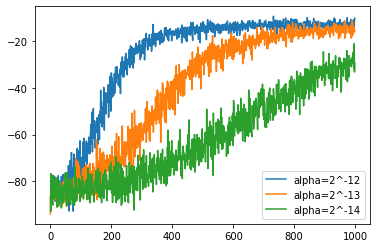

In [5]:
ns,neps = 50,1000
L = [-12,-13,-14]

kwargs = {'bmode':None}

for a in L:
  kwargs['alfa'] = [2**a,0]
  score = run_experiment(ns,neps,kwargs)
  plt.plot(score.mean(0),label='alpha=2^%i'%a)
plt.legend()

### baseline experiment

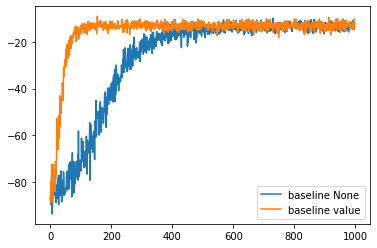

In [6]:
ns,neps = 50,1000

aL = [[2**-12,0],[2**-9,2**-6]]
mL = [None,'value']

for alfa,bmode in zip(aL,mL):
  kwargs = {'alfa':alfa,'bmode':bmode}
  score = run_experiment(ns,neps,kwargs)
  plt.plot(score.mean(0),label='baseline %s'%bmode)
plt.legend()

# notes on replication issues
### initializing gamma
- if initialized to zero vector, the policy is close to optimal, so training shows little/no signs of improvement

### number of updates correlated with episode length
- initially, I set episode max length to 100
    - I did this because I the book figure doesnt go below -100
- additionally, when generating the figure was doing at most 1000 episodes
    - again, I did this because the book figure seemed to assymptote around ep 500
- however,the number of updates made by REINFORCE is proportional to episode length in this task
- the first hint came when I realized I could train from greedy to optimal in 10x more episodes
    - making max episode length 1000 helps
    - this implementation [git](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter13/short_corridor.py) does not set a max number of trials per episode, but instead hard codes an edgecase where softmax is not allowed to saturate on greedy. 
    
### baseline value function
- initially i thought to intitialize a vector of zeros, one for each state. 
    - but this caused instability after episode 50-100 or so
    - i think because the state after the crossed actions is seldom visited
        - later in training, when that state is more often visited, the estimate will be off 
       
 